<a href="https://colab.research.google.com/github/mustafaerdikararmaz/BICE/blob/main/BICE_Lecture2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson 1: PyTorch Training Loop
## Into the fray
The council of Charlemagne was going over their books when they realised that many teams of highly paid historians were occupied with menial transcription work instead of conducting more advanced research. They know automation is possible, but since no one on the council is up to date on modern machine learning architecture (they last worked with SVMs in 380AD) they want to hire you as an outside contractor to setup a simple training loop. Some of the historians already made a start on it, detailed as tutorial below, but they are missing some critical lines. They are also curious about some machine learning phenomena they have heard about and are looking for empirical evidence - see tasks below!

In [19]:
import torch
import torchvision
from torchvision.transforms import v2
import numpy as np
import itertools
from IPython.display import display


## Preparing data
We want to load a simple (ancient) dataset consisting of handwritten numbers 0-9 (MNIST) so we can run some network to classify it later.
![MNIST Dataset](https://upload.wikimedia.org/wikipedia/commons/b/b1/MNIST_dataset_example.png)

We can download it using:

In [20]:
transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True), # Convert to float and re-scale to 0-1
])

train_dataset = torchvision.datasets.MNIST(root='./data/', train=True, download=True, transform=transform) # download MNIST training split into /data
image, label = train_dataset[0] # take the first image as example
print("Image mean and stdv:", image.mean(), image.std())

Image mean and stdv: tensor(0.1377) tensor(0.3125)


However, the neural network math works better if we can assume our inputs to be standard Gaussian. Therefore, we prepare a `transform` function to normalize it; we can use the known mean and standard deviation of the MNIST:

In [21]:
transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize((0.1307,), (0.3081,)) # MNIST mean-stdv
])

train_dataset = torchvision.datasets.MNIST(root='./data/', train=True, download=True, transform=transform) # this time, apply transform
image, label = train_dataset[0] # get a sample again
print("Image mean and stdv:", image.mean(), image.std())

Image mean and stdv: tensor(0.0227) tensor(1.0144)


As you just learned, standard machine learning uses stochastic gradient descent (SGD), i.e. the gradient is estimated with a subset (=batch) of samples.
This is what a DataLoader does: it automatically batches the samples assuming they have the same shape.

In [22]:
batch_size = 16
train_dl = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
  )

test_dataset = torchvision.datasets.MNIST(root='./data/', train=False, download=True, transform=transform)
test_dl = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
)

So we now have our batched dataset ready; let's print the dimensions of a few batches + labels and the corresponding dimensions:

torch.Size([16, 1, 28, 28]) torch.Size([16])


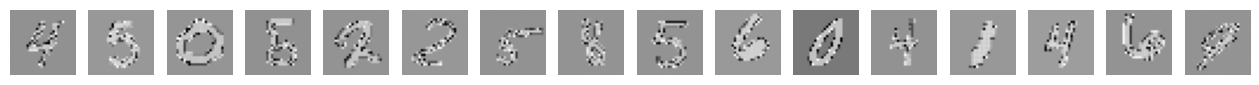

torch.Size([16, 1, 28, 28]) torch.Size([16])


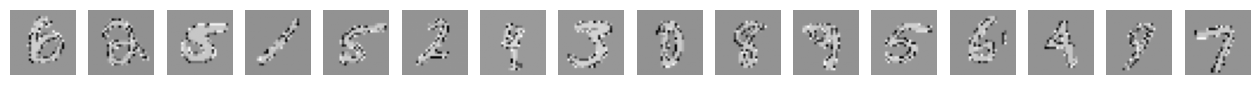

torch.Size([16, 1, 28, 28]) torch.Size([16])


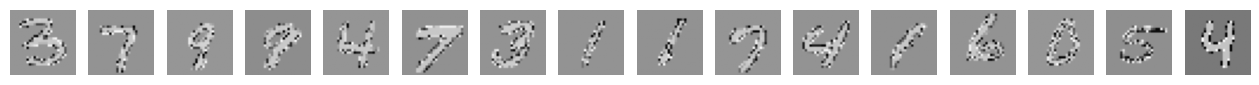

torch.Size([16, 1, 28, 28]) torch.Size([16])


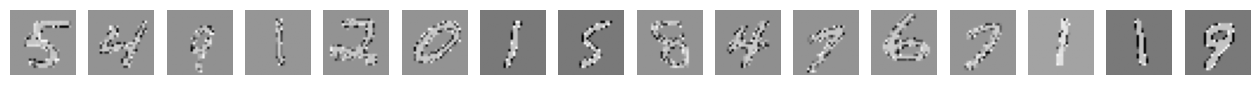

torch.Size([16, 1, 28, 28]) torch.Size([16])


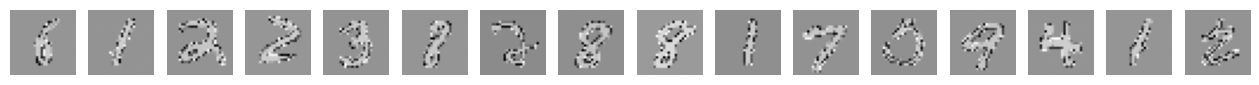

In [23]:
import matplotlib.pyplot as plt

to_pil = v2.ToPILImage()

# Show 5 batches of 16 images each in a row
for image_batch, label_batch in itertools.islice(train_dl, 5):
    print(image_batch.shape, label_batch.shape)  # Expecting (16, 1, 28, 28)

    fig, axs = plt.subplots(1, 16, figsize=(16, 1.5))  # 1 row, 16 columns
    for i in range(16):
        img = to_pil(image_batch[i])
        axs[i].imshow(img, cmap='gray')
        axs[i].axis('off')
    plt.show()

## Our first model
Now that our data is all prepared we want to create a model capable of classifying the digits. To speed this up, we can run it on a GPU (available here via colab) by using the `device` parameter:

In [24]:
# Best practice: Set up a device parameter:
if torch.cuda.is_available():
  print('Set device to CUDA.')
  device = torch.device('cuda')
else:
  print('Warning: Running on CPUs, which will slow down the computations.')
  device = torch.device("cpu")

Set device to CUDA.


## Defining a digit classification model
For our classification task, let's implement a two-layer fully-connected neural network (a.k.a. a 2-layer multi-layer perceptron/MLP).
The input to the network is a batch of images with shape ```(batch_size, num_channels, height_width)=(16, 1, 28, 28)```.
For simplicity, we `flatten` the input to shape ```(batch_size, dim)=(16, 28^2)``` (▶1).

Mathematically, we define our network as

\begin{align}
    a^{(1)}_j &= \sum_i W^{(1)}_{ij}x_j + b_i^{(1)} \\
    o^{(1)}_j &= \text{ReLU}(a^{(1)}_j) \\
    a^{(2)}_j &= \sum_i W^{(2)}_{ij}o^{(1)}_{i} + b^{(2)}_j \\
    o^{(2)}_j &= \text{softmax}(a^{(2)}_j).
\end{align}


For the hidden layer, we use the **rectified linear unit (ReLU)**:
$$
\text{ReLU}(x) = \max(0, x).
$$
For the output layer, we use **softmax**:
$$
\text{softmax}(\mathbf{x})_j = \frac{e^{x_j}}{\sum_k e^{x_k}}.
$$
So, we have a model that takes in an image, and thanks to softmax, it outputs a probability distribution (formally $\sum_j \text{softmax}(\mathbf{x})_j=1$) over the digits.

---
### ✍ Now it's your turn!
1. What should input_size, hiddem_dim and output_dim be? Fill out the ...!
2. Manually implement the `relu(...)` and `softmax(...)` functions.

  💡 Tip: For ReLU, check out `torch.maximum` and `torch.zeros_like`. For softmax, check out `torch.exp` and recall broadcasting, e.g. via `unsqueeze(...)`!



In [29]:
# TODO: Fill in the ...

input_size = 28*28
hidden_dim = 64
output_dim = 10

w1 = torch.empty(input_size, hidden_dim, dtype=torch.float32, device=device, requires_grad=True)
b1 = torch.empty(hidden_dim, dtype=torch.float32, device=device, requires_grad=True)
w2 = torch.empty(hidden_dim, output_dim, dtype=torch.float32, device=device, requires_grad=True)
b2 = torch.empty(output_dim, dtype=torch.float32, device=device, requires_grad=True)

# Initializes tensors with elements in N(0, 0.01)
w1.data.normal_(0, 0.01)
b1.data.normal_(0, 0.01)
w2.data.normal_(0, 0.01)
b2.data.normal_(0, 0.01)


def relu(x):
  """
  Applies ReLU element-wise.
  """
  return torch.maximum(x, torch.zeros_like(x))


def softmax(x):
  """
  Computes softmax over the last axis.

  Args:
    - x: (..., dim)
  Returns:
    (..., dim)
  """
  return torch.exp(x) / torch.sum(torch.exp(x), dim=-1, keepdim=True)


def forward_model(x):
  """
  Args:
    - x: (batch_size, num_channels, height, width)
  Returns:
    Model output (batch_size, output_dim)
  """
  # flatten the image
  x = x.view(batch_size, -1)  # (▶1)

  a1 = torch.einsum('ij,bi->bj', w1, x) + b1
  o1 = relu(a1)

  a2 = torch.einsum('ij,bi->bj', w2, o1) + b2
  o2 = softmax(a2)
  return o2, {
      'a1': a1,
      'o1': o1,
      'a2': a2,
      'o2': o2,
  }

In [30]:
image, label = next(iter(train_dl))
print(image.shape)
with torch.no_grad():
  image = image.to(device)
  o2, _ = forward_model(image)
  o2

torch.Size([16, 1, 28, 28])


## Exercise 1: Optimizing the parameters (4 points)
Now, given an image $\mathbf{x}$ and its label (i.e. digit) $\mathbf{y}$, we want to maximize $\text{softmax}(\mathbf{x})_y$ and minimize $\text{softmax}(\mathbf{x})_j$ for $j\not = y$.

Mathematically, we define a **loss function** $L(\Theta; \mathbf{X}, \mathbf{Y})\rightarrow \mathbb{R}$, which we will **minimize**.
- We minimize w.r.t. the parameters $\Theta$ consisting of the weights $\mathbf{W}$ and biases $\mathbf{b}$ we defined above.
- Batches of images $\mathbf{X}$ and their corresponding labels $\mathbf{Y}$ are used, but not optimized.

### Cross-Entropy loss function
- Since we have a probability distribution, we can define the ground-truth as a probability distribution as well (a Dirac delta distribution $\delta(y)$):
$$p_\text{true}(c)=
\begin{cases}
  1& c=y\\
  0& c\not=y
\end{cases}
$$
- Therefore, we want the loss function to make the model distribution as close as possible to the ground-truth distribution. The 'distance' between probability distributions can be measured using **cross-entropy** (technically, the KL-divergence, but we'll skip the maths here).
$$
\mathcal{L} = -\sum_{c=1}^{C} p_\text{true}(c) \log(\mathbf{o}^{(2)}_c) = -\log(\mathbf{o}_y^{(2)}).
$$
So now we denote $\mathbf{y} = [0 \ldots 1 \ldots 0]$, where the 1 is at index $y$. This is also known as **one-hot encoding**.

### Gradients!
To do so, we perform gradient **descent**, which is pretty simple
1. Compute gradient wrt parameters $\nabla_\Theta L$ at the point $(\mathbf{X}, \mathbf{Y})$.
2. Subtract gradient from parameters with some scaling factor (i.e. **learning rate**) $\lambda$, e.g.
$$
\mathbf{W} \leftarrow \mathbf{W} - \lambda\cdot \nabla_\mathbf{W}L.
$$

If you compute the gradients manually, you would get:
$$
\begin{align*}
\frac{\partial L}{\partial a^{(2)}_i} &= o^{(2)}_i - y_i \\
\frac{\partial L}{\partial b^{(2)}_i} &= \frac{\partial L}{\partial a^{(2)}_i} \\
\frac{\partial L}{\partial W^{(2)}_{ij}} &= \frac{\partial L}{\partial a^{(2)}_j} \cdot o^{(1)}_i \\
\frac{\partial L}{\partial o^{(1)}_i} &= \sum_j W^{(2)}_{ij} \cdot \frac{\partial L}{\partial a^{(2)}_j}\\
\frac{\partial L}{\partial a^{(1)}_j} &= \frac{\partial L}{\partial o^{(1)}_j} \cdot \text{ReLU}'(a^{(1)}_j) \\
\frac{\partial L}{\partial b^{(1)}_j} &= \frac{\partial L}{\partial a^{(1)}_j} \\
\frac{\partial L}{\partial W^{(1)}_{ij}} &= \frac{\partial L}{\partial a^{(1)}_j} \cdot x_i
\end{align*}
$$

Technically, ReLU is non-differentiable at $0$, therefore we arbitrarily define $\text{RELU}'(0)=0$.

### ✍ Now it's your turn!
1. Implement the gradients for all weights and biases. Recall that the outputs and pre-activations have a batch dimension. Use einsums!
At the same time, PyTorch's autograd will compute the gradients automatically. Make sure they are equivalent!

In [31]:
# Load first batch
images, labels = next(iter(train_dl))
images = images.view(batch_size, -1)
labels_onehot = torch.nn.functional.one_hot(labels, num_classes=10)

# (Reset gradients by PyTorch autograd)
w1.grad = None
b1.grad = None
w2.grad = None
b2.grad = None

# Forward pass
_, outputs = forward_model(images)
o2 = outputs['o2']
a2 = outputs['a2']
a1 = outputs['a1']
o1 = outputs['o1']

# TODO: Fill in the ...
dl_da2 = o2 - labels_onehot.float()
assert dl_da2.shape == (batch_size, output_dim)
dl_db2 = dl_da2
assert dl_db2.shape == (batch_size, output_dim)
dl_dW2 = o1.unsqueeze(2) * dl_da2.unsqueeze(1)
assert dl_dW2.shape == (batch_size, hidden_dim, output_dim)
dl_do1 = torch.einsum('bi,ij->bj', dl_da2, w2.T)
assert dl_do1.shape == (batch_size, hidden_dim)
relu_grad = (a1 > 0).float()
dl_da1 = dl_do1 * relu_grad
assert dl_da1.shape == (batch_size, hidden_dim)
dl_db1 = dl_da1
assert dl_db1.shape == (batch_size, hidden_dim)
dl_dW1 = o1.unsqueeze(2) * dl_da1.unsqueeze(1)
assert dl_dW1.shape == (batch_size, input_size, hidden_dim)

# Let autograd compute the gradients
loss = torch.nn.NLLLoss(reduction='mean')(torch.log(o2), labels)
loss.backward()

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat2 in method wrapper_CUDA_bmm)

In [ ]:
# Run this cell to check if your gradients are equivalent to PyTorch's
# Since we set the NLLLoss to reduce the batch axis by mean (i.e. compute loss per batch item, then take average of loss), torch AD returns the mean (over batches) of the gradient we computed.
assert torch.allclose(b2.grad, dl_db2.mean(0))
assert torch.allclose(w2.grad, dl_dW2.mean(0))
assert torch.allclose(w1.grad, dl_dW1.mean(0))
assert torch.allclose(b1.grad, dl_db1.mean(0))
print("If we get here, all gradients correct!")

We now verified that for the first step, gradients between our manual derivations and torch's `.backward` are the same. But what does `.backward` actually do?

## Easy way out: Automatic Differentiation (AD)
Instead of manually computing our derivative methods, we can leave it to PyTorch to trace our forward pass computations and automatically perform the backward pass (gradient calculation) for us. By adding `requires_grad=True` to the tensors we wish to update (weights and biases), PyTorch will record any method call that is performed on them and automatically differentiate through them upon calling `.backward`.

When it is time to use our gradient to update the weights, we can use `with torch.no_grad():` to tell PyTorch that we do not wish these steps compute gradients for that part of the computation (which makes it run a bit faster).

## Actually training
We now want to actually train our model for a given number of epochs. Below is the code and output for the same setup we implemented manually, using torch's functional package for our activation functions and AD to calculate the gradients. One caveat though - we will set the batch size to something rather small.


**You do not need to re-run this snippet, it will take too long.**

In [ ]:
import torch
import torch.nn.functional as F

# re-initialise data loader to have a tiny batch_size
batch_size = 2
train_dl = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=2,
  )

# get dimensions from sample batch
x_sample, y_sample = next(iter(train_dl))
x_sample = x_sample.view(x_sample.size(0), -1)
input_dim = x_sample.shape[1]

# hard-code hyperparameters
num_classes = 10
hidden_dim = 64
epochs = 5
learning_rate = 0.1

# we pass requires_grad=True to tell PyTorch to trace the method calls for the automatic backward pass
w1 = torch.randn(input_dim, hidden_dim, requires_grad=True, device=device)
b1 = torch.zeros(hidden_dim, requires_grad=True, device=device)
w2 = torch.randn(hidden_dim, num_classes, requires_grad=True, device=device)
b2 = torch.zeros(num_classes, requires_grad=True, device=device)

# the optimizer will handle the gradient updates to our weight tensors automatically
optimizer = torch.optim.SGD([w1, b1, w2, b2], lr=learning_rate)

loss_hist = [] # store for later plotting

def forward_model(x):
  """
  Args:
    - x: (batch_size, num_channels, height, width)
  Returns:
    Model output (batch_size, output_dim)
  """
  # flatten the image
  x = x.view(batch_size, -1).to(device)

  a1 = x @ w1 + b1
  y1 = F.relu(a1)

  logits = y1 @ w2 + b2  # "logistic unit", unnormalized probability scores

  return logits

# Training loop
for epoch in range(epochs):
    total_loss = 0.0

    for x, y in train_dl:
        # before:
        # w1.grad = None
        # b1.grad = None
        # w2.grad = None
        # b2.grad = None
        optimizer.zero_grad()  # reset gradients to zero

        # Forward pass
        logits = forward_model(x) # internally stores the outputs, dont need the dict anymore

        # Compute loss
        loss = F.cross_entropy(logits, y.to(device), reduction="mean") # cross entropy = softmax + negative log likelihood
        total_loss += loss.item()

        # Backward pass
        loss.backward() # automatically derive gradients

        # Gradient update
        optimizer.step()  # update weights
        # i.e. param -= learning_rate * param.grad


    loss_hist += [total_loss]
    print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}")

## Classifying samples and calculating accuracy
Let's see how our model did!

In [ ]:
import matplotlib.pyplot as plt

# Re-batch test set too
test_dataset = torchvision.datasets.MNIST(root='./data/', train=False, download=True, transform=transform)
test_dl = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
)

# Plot the loss curve
plt.plot(range(1, epochs + 1), loss_hist, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('Training Loss Curve')
plt.grid(True)
plt.show()

# classify!
correct = 0
total = 0

# We only run the forward pass
with torch.no_grad():
    for x, y in test_dl:
        logits = forward_model(x)
        preds = torch.argmax(logits, dim=1) # get index (class) of highest prediction value
        correct += (preds == y.to(device)).sum().item()
        total += y.size(0)

accuracy = correct / total * 100
print(f"Test Accuracy: {accuracy:.2f}%")

### Verdict: Terrible
Although the loss does go down, it stagnates at rather high high values. Accuracy anywhere lower than 80-90% is rather bad for a model as simple as MNIST. This happened because we set our batch size too low, feeding the model only one image each step.

## Exercise 2: Implement Gradient Accumulation (3 points)
Hyperparameters like learning rate, batch size are often chosen very empirically by running various combinations and simply picking the best.

Generally, a higher batch size will result in faster training (more samples to parallelize on a GPU) but may hurt generalisation as the noise introduced by individual samples is lost. It also comes with a higher memory footprint, which makes batches beyond a certain size impractical on constrained systems. On the other hand, a very small batch size can make a model overfit by introducing too much noise - variance will be huge and the model likely won't converge.

**Exercise**: To solve our problem we would simply need to increase the batch size - however, let's imagine that we are running on some specialized hardware that cannot hold more than a single image at once in memory!

This is where gradient accumulation comes in - a trick to increase the effective batch size by averaging over gradients for different batches, effectively only performing a gradient update every $N$ steps. Below is a copy of our autograd network from before; implement gradient accumulation and compare the accuracy and loss curve to the output from above!

Keep in mind that cross-entropy loss is internally taking the mean over the batches it sees. Since we are now accumulating multiple batches before updating, you will need to normalize the gradient by the `batch_multiplier` every step.

In [ ]:
import torch
import torch.nn.functional as F

batch_size = 4
train_dl = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=2,
  )

# TODO: use this constant to only compute the backward pass every `batch_multiplier` iterations
# E.g. an effective multiplier of 4 with a batch size of 4 would result in an effective batch size of 16
batch_multiplier = 4

# get dimensions from sample batch
x_sample, y_sample = next(iter(train_dl))
x_sample = x_sample.view(x_sample.size(0), -1)
input_dim = x_sample.shape[1]

# hard-code hyperparameters
num_classes = 10
hidden_dim = 64
epochs = 10
learning_rate = 0.1

# we pass requires_grad=True to tell PyTorch to trace the method calls for the automatic backward pass
w1 = torch.randn(input_dim, hidden_dim, requires_grad=True, device=device)
b1 = torch.zeros(hidden_dim, requires_grad=True, device=device)
w2 = torch.randn(hidden_dim, num_classes, requires_grad=True, device=device)
b2 = torch.zeros(num_classes, requires_grad=True, device=device)

# the optimizer will handle the gradient updates to our weight tensors automatically
optimizer = torch.optim.SGD([w1, b1, w2, b2], lr=learning_rate)

loss_hist = [] # store for later plotting

def forward_model(x):
  """
  Args:
    - x: (batch_size, num_channels, height, width)
  Returns:
    Model output (batch_size, output_dim)
  """
  # flatten the image
  x = x.view(batch_size, -1).to(device)

  a1 = x @ w1 + b1
  y1 = F.relu(a1)

  logits = y1 @ w2 + b2  # "logistic unit", unnormalized probability scores

  return logits

# Training loop
for epoch in range(epochs):
    total_loss = 0.0

    for batch_idx, (x, y) in enumerate(train_dl): # Hint: use the batch_idx!
        # Forward pass
        logits = forward_model(x)

        loss = F.cross_entropy(logits, y.to(device), reduction="mean") # cross entropy = softmax + negative log likelihood
        # TODO: normalize

        total_loss += loss.item()

        # Backward pass
        loss.backward() # automatically derive gradients

        # TODO: do not update every step
        optimizer.step()
        optimizer.zero_grad()

    loss_hist += [total_loss]
    print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}")

## Results
Much better! It could probably benefit from an even larger (effective) batch size, but the improvement should be clearly visible.

## Implementing larger models
For now, we directly defined the weights and biases of our model.
This is a good way to think about neural networks, otherwise, we're just stacking legos.

That being said, for larger models, it's easier to stack legos. Let's start with a simple `nn.Module`.



In [ ]:
import torch
import torch.nn as nn

class LinearLayer(nn.Module):
  def __init__(self, in_dim, out_dim):
    super().__init__()  # calls __init__() of nn.Module(), which does some magic

    self.weight = nn.Parameter(
        torch.empty(in_dim, out_dim)
    )
    self.bias = nn.Parameter(
        torch.empty(out_dim)
    )

    # Initialize with N(0, 0.01)
    # Access the underlying tensor via `.data` to avoid gradient computations
    self.weight.data.normal_(0, 0.01)
    self.bias.data.normal_(0, 0.01)

  def forward(self, x):
    return torch.einsum("io,bi->bo", self.weight, x) + self.bias

lin_layer = LinearLayer(4, 8)

Think of an nn.Module of a "container" that holds a set of `nn.Parameter` (which are also `nn.Module`s) and also other `nn.Module`s, i.e. you can "nest" modules.

The container also defines the computation function via `forward(...)`.
The forward function can take arbitrary arguments and return arbitrary tensors and non-tensors.

If you set `self.somename = some_module` and `some_module` is a `nn.Module` (like `nn.Parameter`), they are found automatically and treated specially:

In [ ]:
print(dict(lin_layer.named_parameters()))

This allows you to create an optimizer without manually passing each parameter:

In [ ]:
# before:
# optimizer = torch.optim.SGD([w1, b1, w2, b2], lr=learning_rate)
optimizer = torch.optim.SGD(lin_layer.parameters(), lr=0.1)
print(optimizer.param_groups)

Also, you can move the whole module to a different device or dtype.

In [ ]:
print("before: ", lin_layer.weight.device, lin_layer.bias.dtype)
lin_layer.to(device='cuda', dtype=torch.float16)
print("after: ", lin_layer.weight.device, lin_layer.bias.dtype)

## Exercise 3: A generic multilayer perceptron (2 points)
Write an `nn.Module` class that - given the input dimension and the output dimensions - builds a multilayer perceptron (MLP) of arbitrary depth and width. Each layer is followed by a ReLU activation, except for the output layer.
Following the previous exercises, set the default argument for `input_dim = 28*28` and the default argument for `output_dims=(128, 10)`.

You can use [`nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) and [`nn.ReLU`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html) or better yet [`torch.nn.functional.relu`](https://pytorch.org/docs/stable/generated/torch.nn.functional.relu.html).
You will have to declare a list of Modules. You **cannot** just assign a list/tuple, i.e.
```python
def __init__(self, ...):
  self.layers = [nn.SomeLayer(...) for dim in dims]  # wrong!!
```
since `self.layers` is not an nn.Module. To fix that, you can use a `nn.ModuleList`
```python
def __init__(self, ...):
  self.layers = nn.ModuleList([nn.SomeLayer(...) for dim in dims]) # fixed, now self.layers is detected as a module
  self.layers.append(nn.SomeLayer(...))

def forward(...):
  for layer in layers:
    y = layer(x)
    ...
```

For example, given `input_dim=16` and `output_dims=(32, 16, 8)`, we expect a 3-layer MLP with
- layer 1: `W.shape=(16, 32)`, `b.shape=(32,)`
- ReLU activation
- layer 2: `W.shape=(32, 16)`, `b.shape=(16,)`
- ReLU activation
- layer 3: `W.shape=(16, 8)`, `b.shape=(8,)`
- no activation!

In [ ]:
class MLP:
  ...

## Bias-variance tradeoff
What happens if you make a model larger (more parameters)?
In other words, you increase model complexity.
Looking up statistical machine learning literature, you would find the concept of the **bias-variance tradeoff**.

Let's first talk about possible sources of errors, some of which you already encountered during the gradient accumulation exercise:
- **Noise** of the data

  Your dataset might just be **noisy** (in fact, MNIST has 4 wrong labels).
- **Bias** of a model:

  The model is not flexible enough to fit to the true data distribution.
- **Variance** of a model:

  The model fits 'too much' to the data, potentially fitting to noise.

The bias-variance tradeoff now states that as we increase model capacity, we **decrease** the bias and **increase** variance.

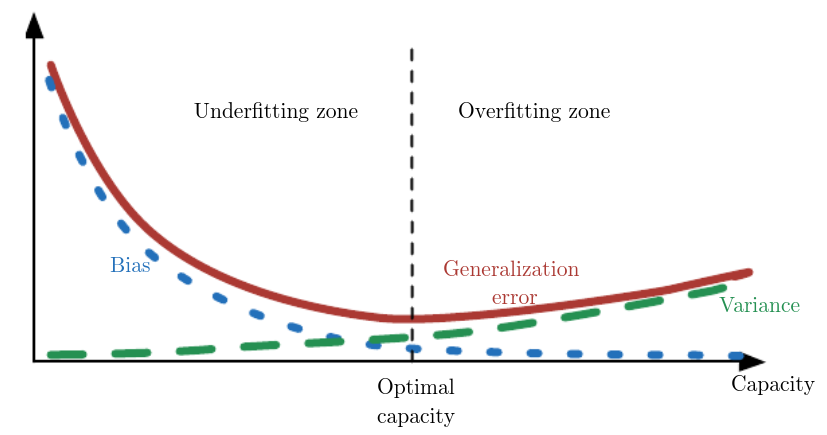

[from **Deep Learning** (Goodfellow 2016)]

A standard example is to fit a polynomial. In this case, increasing the degree of the polynomial increases model capacity.

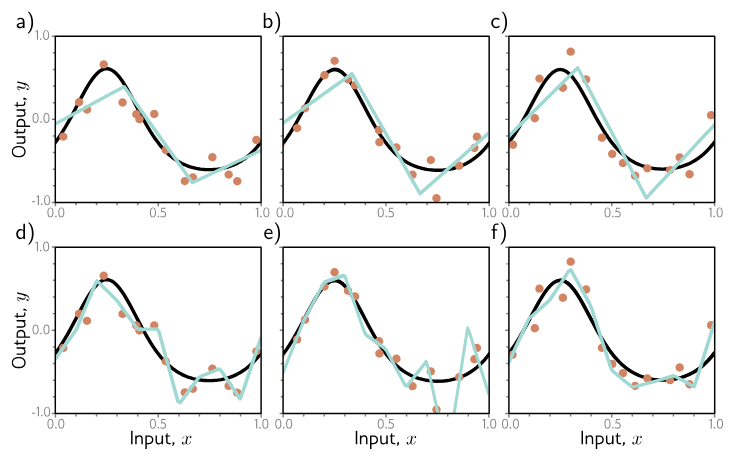

[from **Deep Learning** (Goodfellow 2016)]

## Exercise 4: Double Descent (2 points)
Turns out for deep learning, we observe a counterintuitive result:
we see the described bias-variance tradeoff behavior up until the **interpolation threshold** at
$$
n\cdot K
$$
where $n$ is the number of training samples and $K$ is the number of outputs.

Let's take a random subset of MNIST such that $n=4000$.

In [ ]:
n_samples = 4000

In [ ]:
import torch
from torchvision import datasets
from torchvision.transforms import v2
from sklearn.model_selection import StratifiedShuffleSplit

transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize((0.1307,), (0.3081,)) # MNIST mean-stdv
])

train_dataset = datasets.MNIST(root='./data/', train=True, download=True, transform=transform) # this time, apply transform
splitter = StratifiedShuffleSplit(n_splits=1, test_size=n_samples, random_state=42)
_, sample_idx = next(splitter.split(X=torch.zeros(len(train_dataset)), y=train_dataset.targets))
from torch.utils.data import Subset
train_dataset = Subset(train_dataset, sample_idx)

print(f"Train dataset has {len(train_dataset)} samples")


**Now it's your turn!**

We expect the threshold to be at $4000\cdot10=40000$ parameters [(Belkin et al., 2019)](https://pmc.ncbi.nlm.nih.gov/articles/PMC6689936/pdf/pnas.201903070.pdf).

Let's train MLPs with [3000, 5000, 7000, 10000, 20000, 30000, 32000, 34000, 36000, 38000, 40000, 50000, 60000, 100000, 300000, 500000] parameters, exploring the number of parameters around 40k.

Assume a 2-layer MLP. The input dimension for MNIST is $28\cdot 28=784$, the output dimension is $10$.

We want to find a size for our hidden layer such that, given the input and output dimension, it adds up to the given number of parameters $P$.

$$h(P)=\ldots$$

Round down to the nearest integer ($\lfloor h(P) \rfloor$) and implement the function below.

In [ ]:
import torch
import torch.nn.functional as F
import math
import torchvision

epochs = 2
batch_size = 128
learning_rate = 5e-3
train_dl = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=2,
  )

test_dataset = torchvision.datasets.MNIST(root='./data/', train=False, download=True, transform=transform)
test_dl = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=2,
)


def h(P):
  # TODO: calculate hidden layer size based on params and in/out dim shapes
  return math.floor(...)

loss_hist = [] # store for later plotting
parameters = (3000, 5000, 7000, 10000, 20000, 30000, 32000, 34000, 36000, 38000, 40000, 50000, 60000, 100000, 300000, 500000)

for hidden_dim in (h(num_params) for num_params in parameters):
  # TODO: initialize your MLP from the previous exercise here
  mlp = ...
  print(f'num_params={sum(x.numel() for x in mlp.parameters())}')

  mlp.to(device)
  # the optimizer will handle the gradient updates to our weight tensors automatically
  optimizer = torch.optim.SGD(mlp.parameters(), lr=learning_rate)
  for epoch in range(epochs):
      # Training
      for x, y in train_dl:
          x = x.view(batch_size, -1).to(device)
          logits = mlp(x)
          loss = F.cross_entropy(logits, y.to(device), reduction="mean")
          loss.backward()
          optimizer.step()
          optimizer.zero_grad()

  # Evaluate on test
  test_loss = 0.0
  for x, y in test_dl:
    with torch.no_grad():
        x = x.view(x.shape[0], -1).to(device)
        logits = mlp(x)
        test_loss += F.cross_entropy(logits, y.to(device), reduction="mean")
  loss_hist.append(test_loss / len(test_dl))
  print(f"Loss {hidden_dim=} = {test_loss:.4f}")



Let's see if we can observe double descent!

In [ ]:
import matplotlib.pyplot as plt

# Plot the loss curve
plt.plot(parameters, [x.item() for x in loss_hist], marker='o')
plt.xlabel('Epoch')
plt.ylabel('Test Loss')
plt.xscale('log')
plt.title('Test Loss Curve')
plt.grid(True)
plt.show()

You should see something like the image below; don't worry if it does not look quite as smooth. Feel free to play around with batch size and other hyperparameters to improve the result!


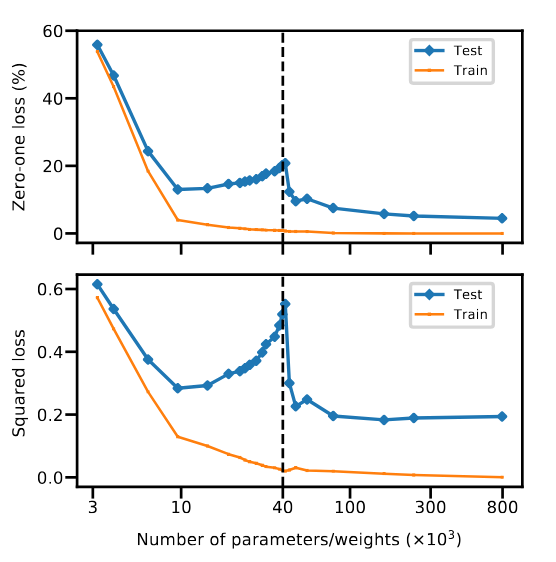